In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
import torch
from src.data.loaders import MitoSemsegDataset
from src.analysis.components import get_mito_stats, crop_all_mitos, get_cristae_mask
from src.visualization.analysis import show_mito_stats

dataset = MitoSemsegDataset(root=TRAIN_ROOT)
img, mask = dataset[81]

In [3]:
from functools import partial
from src.analysis.components import bottomhat, close_rc, area_filter, prune, close, holefill, contour_smoothing
import ipywidgets as widgets

@widgets.interact(sesize=(1,100,1),ksize=(1,100,2),type=[('cross',cv.MORPH_CROSS),('disc',cv.MORPH_ELLIPSE),('rect',cv.MORPH_RECT)],low=(0,255),up=(0,255),thres=(0,500),p=(0.01,1.,0.01))
def plot(sesize=25, ksize=22, type=cv.MORPH_ELLIPSE,low=0,up=65,thres=120,p=0.2):
    mitos, masks = crop_all_mitos(img, mask)
    imasks = [cv.bitwise_not(m) for m in masks]
    masks = [cv.erode(m, kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(25,25))) for m in masks]
    n = min(10,len(mitos))
    
    cristae = []
    for i in range(n):
        y = cv.equalizeHist(mitos[i])
    
        y = cv.equalizeHist(bottomhat(y, sesize, cv.MORPH_ELLIPSE))
        y = close_rc(y, 4, cv.MORPH_RECT) # pepper noise removal

        y = cv.inRange(y,lowerb=low,upperb=up) # BW thresholding
        y = cv.bitwise_and(y,masks[i]) # remove outer membrane

        y = prune(y,15) # thin spur removal
        y = close(y,3) # gap closing
        y = holefill(y)
        y = area_filter(y,thres) # small component removal
        
        y = contour_smoothing(y,p)
        y = prune(y,15)
        
        cristae.append(y)

    widths = [x.shape[1] for x in cristae]

    fig = plt.figure(figsize=(2*n,8))
    gs = fig.add_gridspec(2, n, hspace=0, wspace=0, width_ratios=widths)
    ax = gs.subplots()
    for i in range(n):
        ax[0,i].axis('off'), ax[1,i].axis('off')
        ax[0,i].imshow(np.bitwise_or(mitos[i],imasks[i]), cmap='gray')
        ax[1,i].imshow(cristae[i], cmap='gray')

interactive(children=(IntSlider(value=25, description='sesize', min=1), IntSlider(value=22, description='ksize…

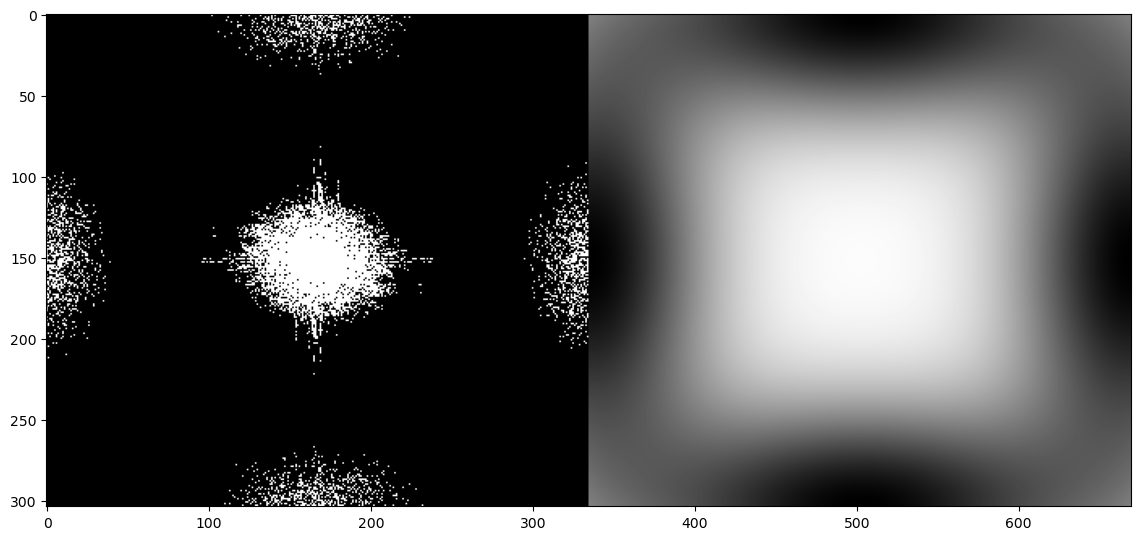

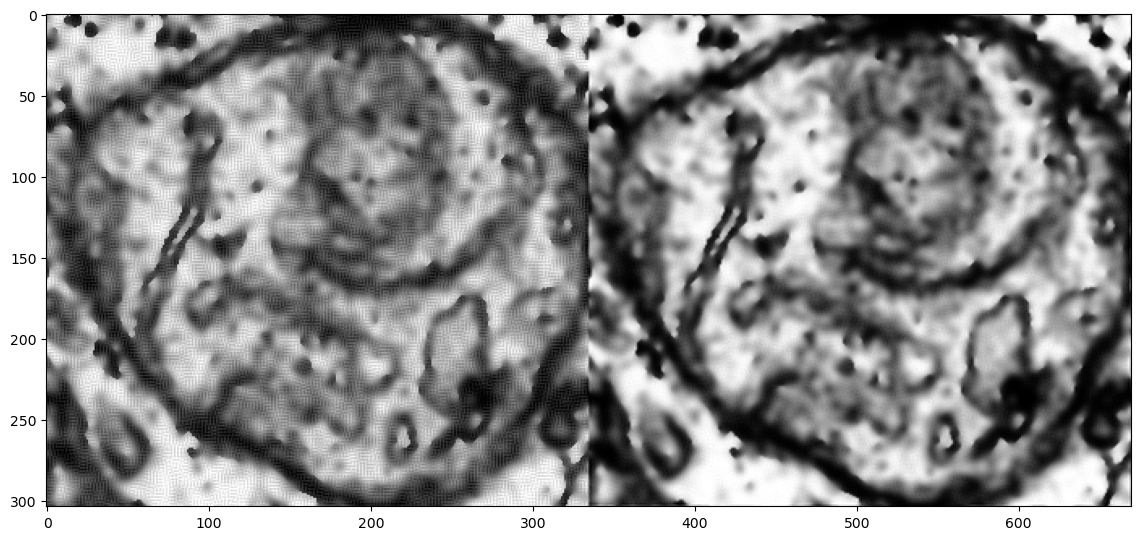

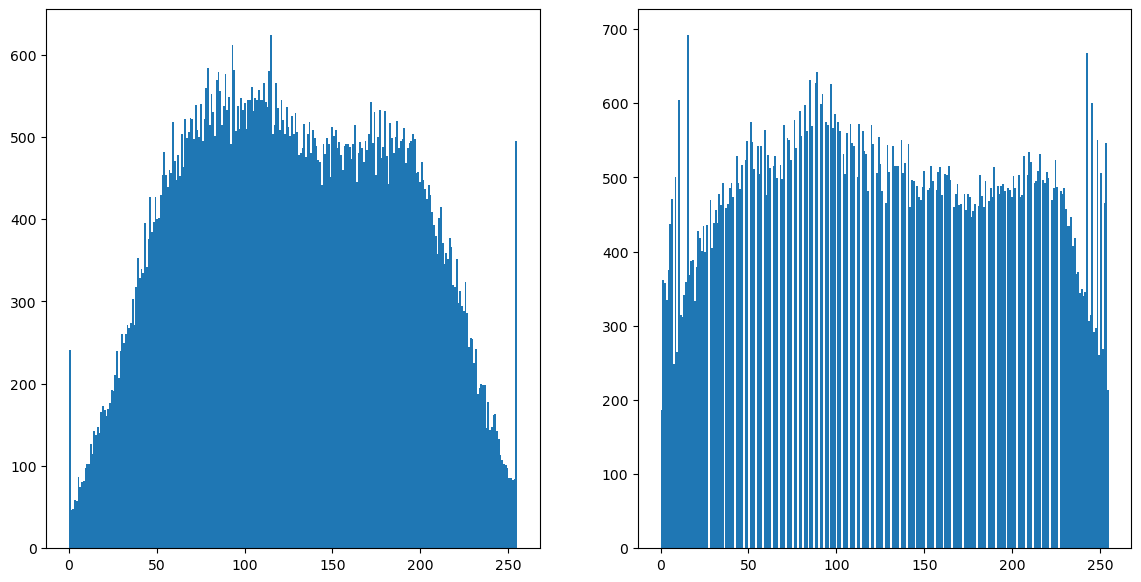

In [7]:
plt.rcParams["figure.figsize"] = [14, 7]
mitos, masks = crop_all_mitos(img, mask)
x = mitos[8]

x = cv.equalizeHist(x)
x = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
x = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(x, alpha=0.25, K=0.25, niters=5), code=cv.COLOR_RGB2GRAY)

X = cv.dft(np.float32(x),flags=cv.DFT_COMPLEX_OUTPUT)
X = np.fft.fftshift(X)
P = 20*np.log(cv.magnitude(X[:,:,0],X[:,:,1]))

m, n, _ = X.shape
x_coords = np.arange(-n//2,n//2)
y_coords = np.arange(-m//2,m//2)
xv, yv = np.meshgrid(x_coords,y_coords)

cutoff_edge = 0.6
cutoff_center = 0.3
a_v = int(cutoff_edge*n/2)
b_v = int(cutoff_center*m/2)
a_h = int(cutoff_center*n/2)
b_h = int(cutoff_edge*m/2)

cx, cy = n//2, m//2 # centers of four notch filters (0,-cy),(-cx,0),(cx,0),(0,cy)
H = (np.exp(-((xv/a_v)**2 + ((yv-cy)/b_v)**2)/2)
    + np.exp(-(((xv-cx)/a_h)**2 + (yv/b_h)**2)/2)
    + np.exp(-(((xv+cx)/a_h)**2 + (yv/b_h)**2)/2)
    + np.exp(-((xv/a_v)**2 + ((yv+cy)/b_v)**2)/2))
H = 1.-H

plt.imshow(np.concatenate([cv.normalize(P,None,1,0,cv.NORM_MINMAX,cv.CV_32S),H],axis=1),cmap='gray');

Y = X*H[:,:,None]

y = cv.idft(np.fft.ifftshift(Y), flags=cv.DFT_REAL_OUTPUT+cv.DFT_SCALE)
y = cv.equalizeHist(cv.normalize(y, None, 255, 0, cv.NORM_MINMAX, cv.CV_8U))

plt.figure()
plt.imshow(np.concatenate([x,y],axis=1),cmap='gray');

plt.figure()
plt.subplot(121), plt.hist(x.ravel(),256,[0,255]);
plt.subplot(122), plt.hist(y.ravel(),256,[0,255]);

In [8]:
from src.analysis.components import demaze
@widgets.interact(a=(0.05,1,0.05),k=(0.05,1,0.05),niters=(1,15,1))
def aniso(a=0.25,k=0.2,niters=5):
    mitos, masks = crop_all_mitos(img, mask)
    x = cv.equalizeHist(mitos[8])

    y = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
    y = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(y, alpha=a, K=k, niters=niters), code=cv.COLOR_RGB2GRAY)
    y = demaze(y)
    Y = np.fft.fftshift(cv.dft(np.float32(y),flags=cv.DFT_COMPLEX_OUTPUT+cv.DFT_SCALE))
    P = 20*np.log(cv.magnitude(Y[:,:,0],Y[:,:,1]))

    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

    plt.figure(figsize=(5,5))
    plt.imshow(cv.normalize(P,None,1,0,cv.NORM_MINMAX,cv.CV_32S),cmap='gray')

interactive(children=(FloatSlider(value=0.25, description='a', max=1.0, min=0.05, step=0.05), FloatSlider(valu…

In [9]:
@widgets.interact(thres1=(0,50000,10),thres2=(0,90000,10),apt=(3,7,2),l2=True)
def canny(thres1=15000,thres2=75000,apt=7,l2=True):
    mitos, masks = crop_all_mitos(img, mask)
    x = cv.equalizeHist(mitos[1])
    y = cv.cvtColor(x, code=cv.COLOR_GRAY2RGB)
    y = cv.cvtColor(cv.ximgproc.anisotropicDiffusion(y, alpha=0.2, K=0.2, niters=5), code=cv.COLOR_RGB2GRAY)
    y = demaze(y)
    y = cv.Canny(y, threshold1=thres1, threshold2=thres2, apertureSize=apt, L2gradient=l2)

    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

interactive(children=(IntSlider(value=15000, description='thres1', max=50000, step=10), IntSlider(value=75000,…

In [10]:
from src.analysis.components import open_rc, close_rc, bottomhat, bottomhat_rc, area_filter, open, close, prune, holefill, contour_smoothing, dilate_rc

@widgets.interact(sesize=(1,100,1),ksize1=(1,100),ksize2=(1,100),type=[('cross',cv.MORPH_CROSS),('disc',cv.MORPH_ELLIPSE),('rect',cv.MORPH_RECT)],low=(0,255),up=(0,255),thres=(0,500),p=(0.01,1.,0.01))
def morph(sesize=25,ksize1=4,ksize2=10,type=cv.MORPH_ELLIPSE,low=0,up=65,thres=120,p=0.2):
    mitos, masks = crop_all_mitos(img, mask)
    i = 10
    
    m = masks[i]
    m = cv.erode(m, kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(25,25)))
    x = cv.equalizeHist(mitos[i])
    
    y = close_rc(x, 4, cv.MORPH_RECT) # pepper noise removal
    
    kernel = cv.getStructuringElement(cv.MORPH_CROSS,(ksize2,ksize2))
    kernel = cv.bitwise_or(kernel, np.eye(ksize2, dtype=np.uint8))
    kernel = cv.bitwise_or(kernel, np.fliplr(np.eye(ksize2, dtype=np.uint8)))
    
    y = open_rc(y, kernel)

    y1 = cv.equalizeHist(bottomhat(y, ksize1, type))
    y =  cv.equalizeHist(bottomhat_rc(y, ksize2, type))
    y = dilate_rc(marker=y, mask=y1)

    # y = cv.inRange(y,lowerb=low,upperb=up) # BW thresholding
    # y = cv.bitwise_and(y,m) # remove outer membrane

    # y = prune(y,15) # thin spur removal
    # y = close(y,3) # gap closing
    # y = holefill(y)
    # y = area_filter(y,thres) # small component removal
    
    # y = contour_smoothing(y,p)
    # y = prune(y,15)

    plt.figure(figsize=(15,7))
    plt.imshow(np.concatenate([x,y],axis=1),cmap='gray')

interactive(children=(IntSlider(value=25, description='sesize', min=1), IntSlider(value=4, description='ksize1…